In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import streamlit as st
import seaborn as sns
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report







import kaggle

In [9]:
kaggle.api.authenticate()
dataset_url = 'ravirajsinh45/real-life-industrial-dataset-of-casting-product'
kaggle.api.dataset_download_files(dataset_url, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product


In [10]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

In [13]:
# get data 
#menentukan satu set nilai lain untuk parameter 'flow_from_directory':
IMAGE_DIR = "./casting_data/casting_data/"
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "train",
                                        subset = "training", shuffle = True, **gen_args)
validation_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "train",
                                        subset = "validation", shuffle = True, **gen_args)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.


In [14]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "test",
                                                  shuffle = False,
                                                  **gen_args)

Found 715 images belonging to 2 classes.


In [15]:
mapping_class = {0: "normal", 1: "defect"}
mapping_class

{0: 'normal', 1: 'defect'}

In [16]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

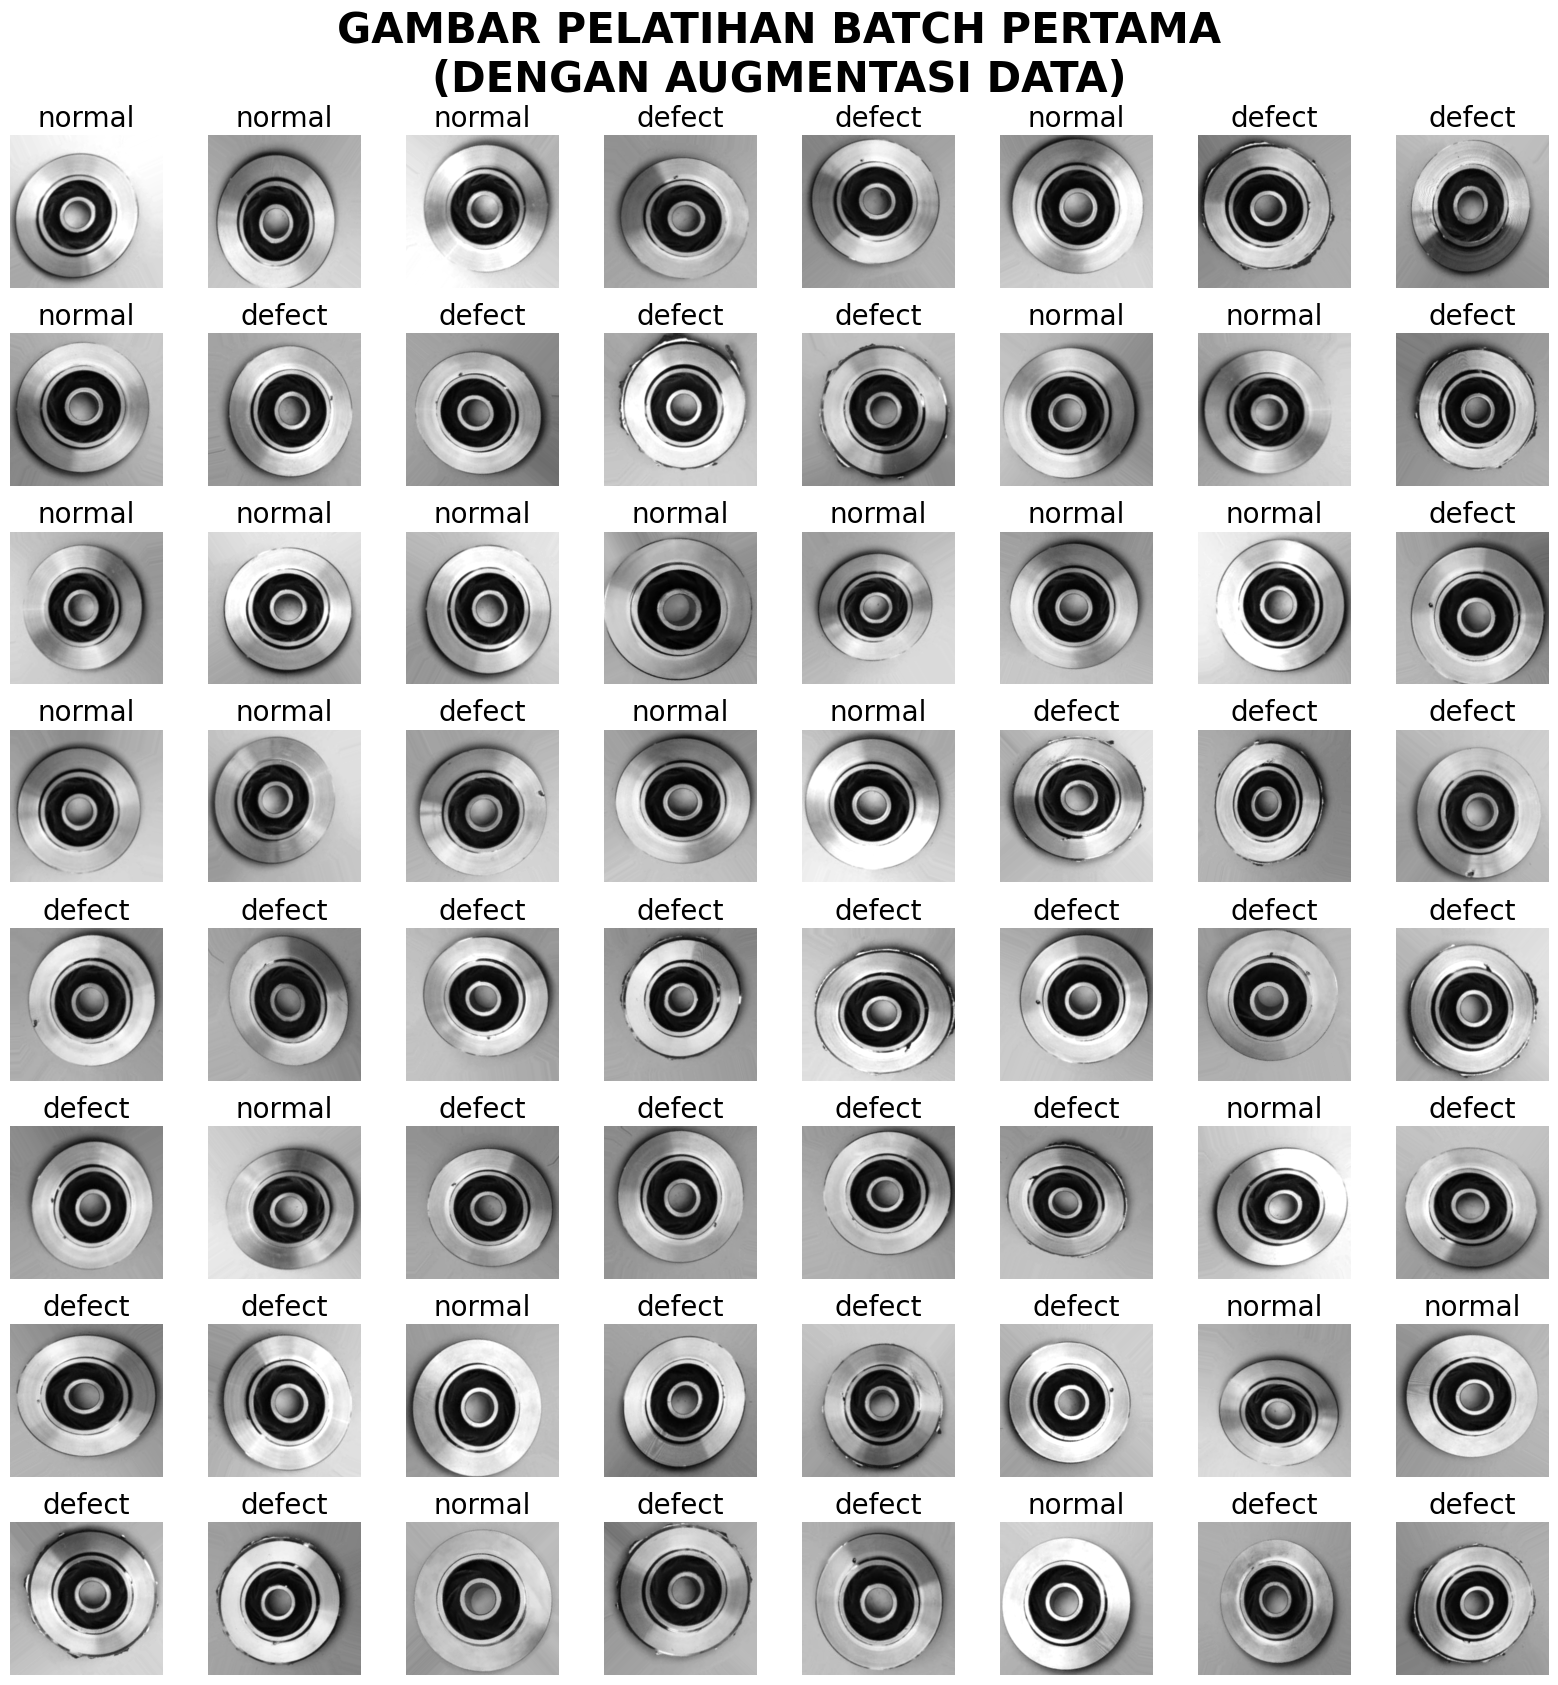

In [17]:
train_images = visualizeImageBatch(train_dataset,
                                   "GAMBAR PELATIHAN BATCH PERTAMA\n(DENGAN AUGMENTASI DATA)")

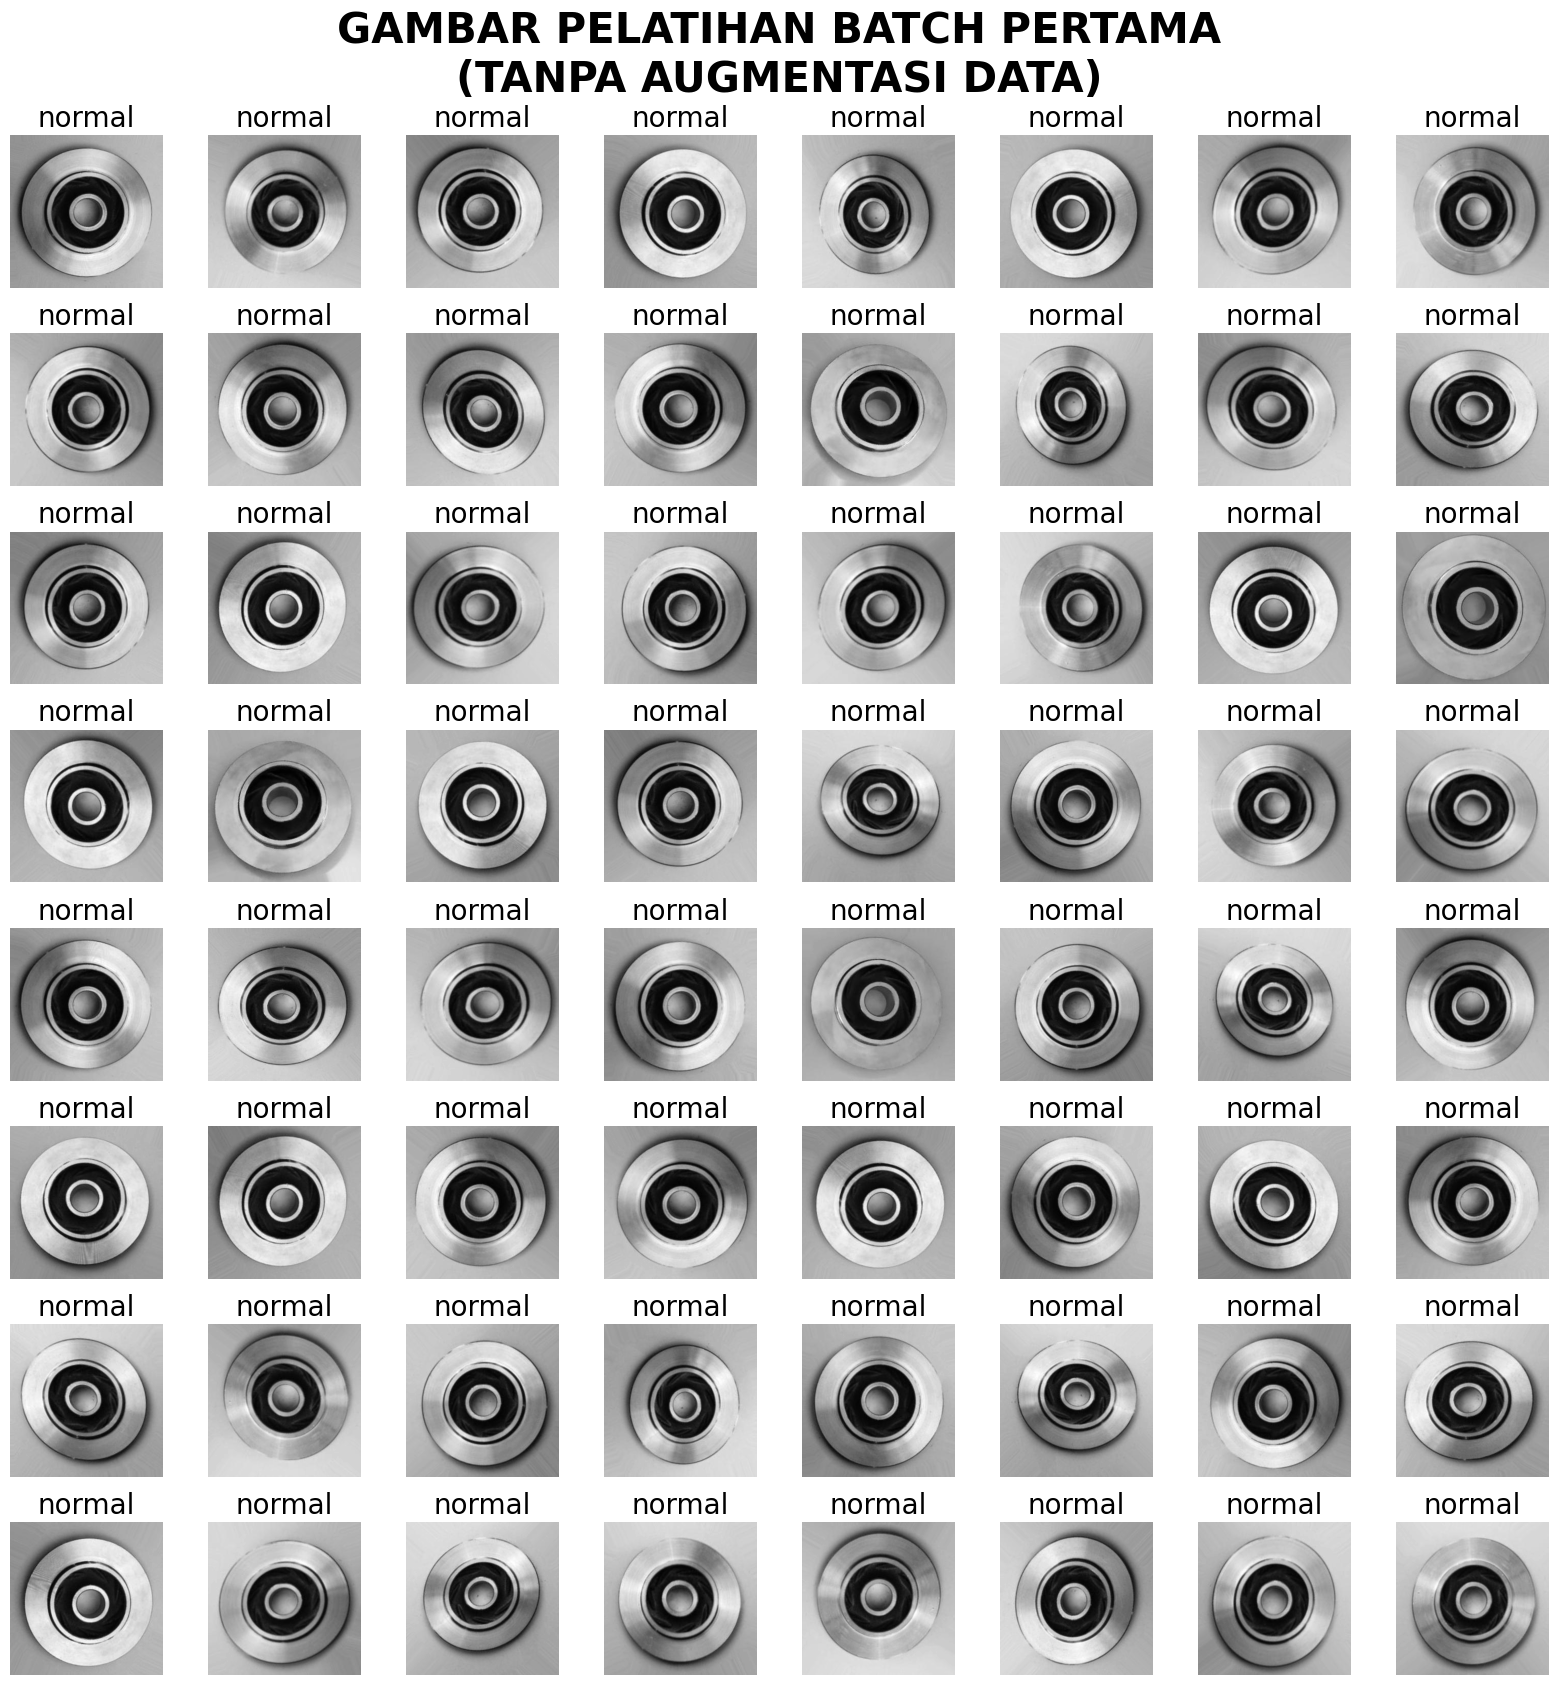

In [18]:
test_images = visualizeImageBatch(test_dataset,
                                  "GAMBAR PELATIHAN BATCH PERTAMA\n(TANPA AUGMENTASI DATA)")

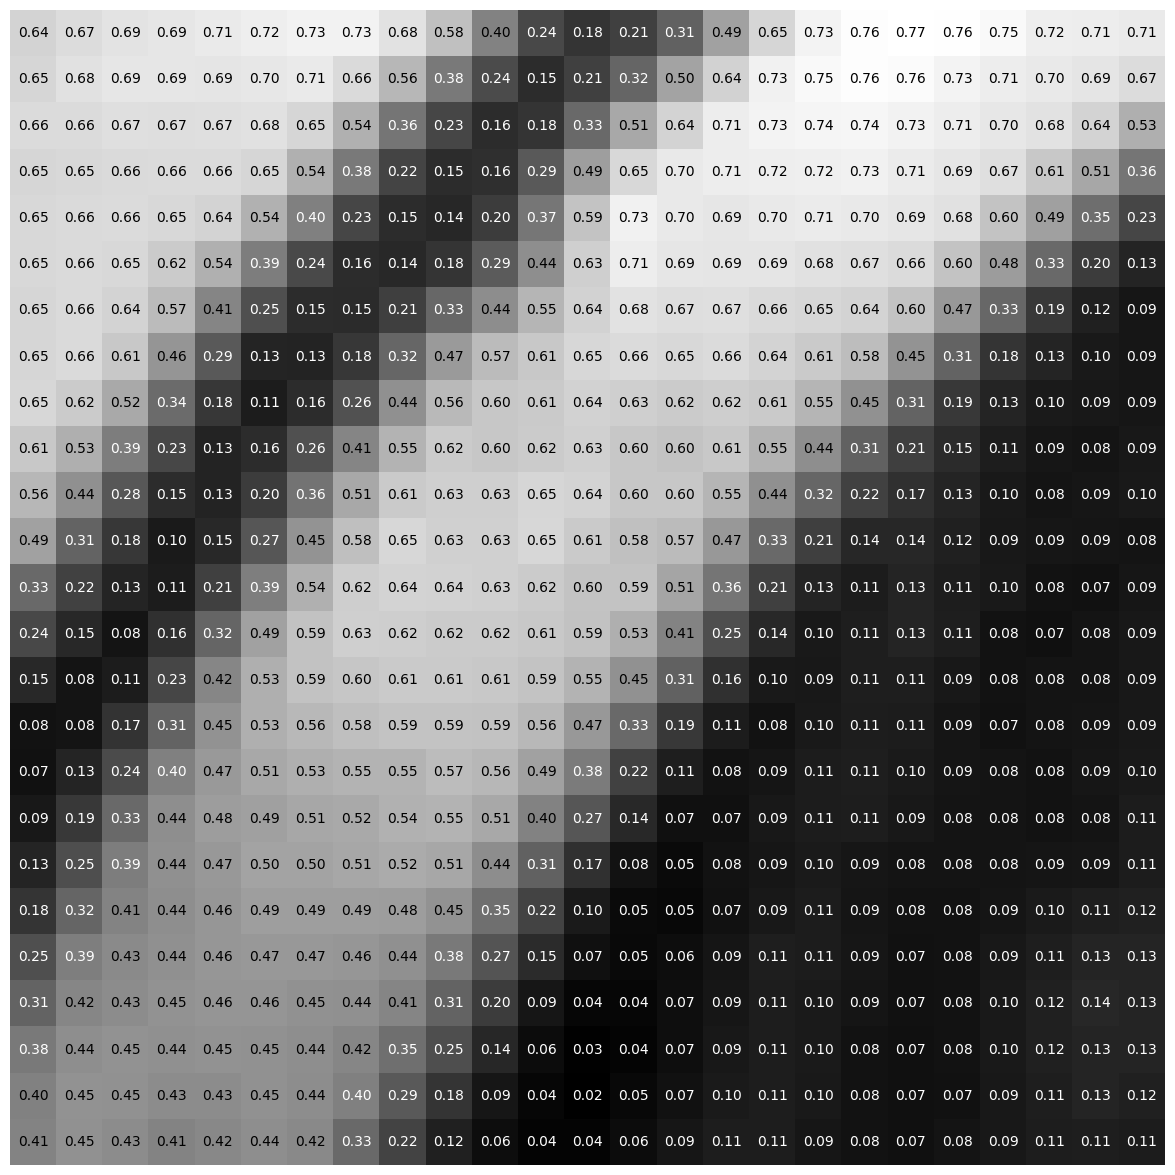

In [19]:
img = np.squeeze(train_images[4])[75:100, 75:100]

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = "gray")
ax.axis("off")

w, h = img.shape
for x in range(w):
    for y in range(h):
        value = img[x][y]
        ax.annotate("{:.2f}".format(value), xy = (y,x),
                    horizontalalignment = "center",
                    verticalalignment = "center",
                    color = "white" if value < 0.4 else "black")

In [20]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", input_shape=IMAGE_SIZE + (1, )))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=16, kernel_size=3, strides=2, activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation="sigmoid"))

C:\Users\opiks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 149, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 36, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 676,945 (2.58 MB)

 Trainable params: 676,945 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
checkpoint = ModelCheckpoint('model/cnn_casting.keras', verbose=1, save_best_only=True, monitor='val_loss', mode='min')

model.fit(train_dataset, validation_data=validation_dataset, batch_size=16, epochs=10, callbacks=[checkpoint], verbose=1)


Epoch 1/10


C:\Users\opiks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5621 - loss: 0.6801
Epoch 1: val_loss improved from inf to 0.61221, saving model to model/cnn_casting.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5625 - loss: 0.6799 - val_accuracy: 0.6810 - val_loss: 0.6122
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.6861 - loss: 0.5862
Epoch 2: val_loss improved from 0.61221 to 0.48143, saving model to model/cnn_casting.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 78s 896ms/step - accuracy: 0.6863 - loss: 0.5859 - val_accuracy: 0.7436 - val_loss: 0.4814
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.7621 - loss: 0.4804
Epoch 3: val_loss improved from 0.48143 to 0.36252, saving model to model/cnn_casting.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 958ms/step - accuracy: 0.7623 - loss: 0.4802 - val_accuracy: 0.8386 - val_loss: 0.3625
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.8238 - loss: 0.3838
Epoch 4: val_loss improved from 0.36252 to 0.2

In [24]:
model.save("models.h5")

In [26]:
tf.keras.models.save_model(model,'/Users/opiks/CapstoneProject37/')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/Users/opiks/CapstoneProject37/.

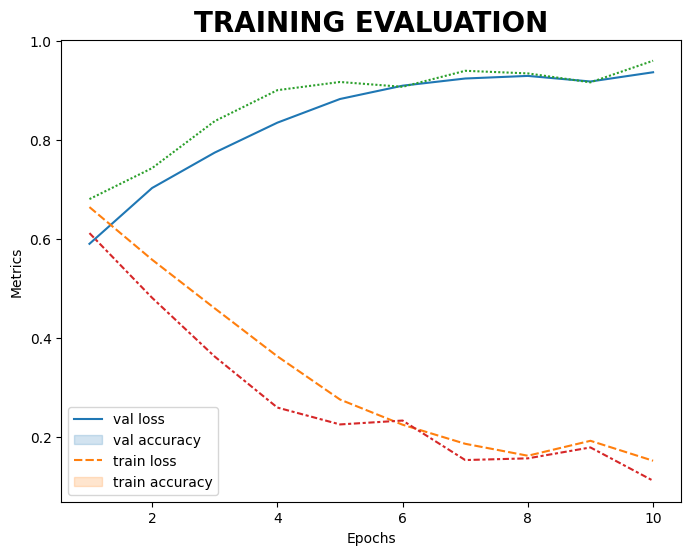

In [33]:
plt.subplots(figsize=(8, 6))
sns.lineplot(data=pd.DataFrame(model.history.history, index=range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight="bold", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend(labels=['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()


In [37]:
#Model berkinerja sangat baik pada kumpulan data pelatihan dan validasi yang menggunakan gambar yang diperbesar. 
#Selanjutnya, Menguji performa model kami dengan gambar yang tidak terlihat dan tidak ditambah

# save model
#best_model = load_model("model/cnn_casting_inspection_model.keras")
# save model
best_model = load_model("model/cnn_casting.keras")

In [38]:
y_pred_prob = best_model.predict(test_dataset)

C:\Users\opiks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 526ms/step


In [41]:
#Keluaran dari prediksi tersebut berupa probabilitas. disini Kami menggunakan THRESHOLD = 0,5 untuk memisahkan kelas. 
#Jika probabilitasnya lebih besar atau sama dengan THRESHOLD maka akan tergolong cacat, jika tidak oke
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

Predicted       
                     ok defect
Actual ok           260      2
       defect        14    439

In [44]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.9489    0.9924    0.9701       262
           1     0.9955    0.9691    0.9821       453

    accuracy                         0.9776       715
   macro avg     0.9722    0.9807    0.9761       715
weighted avg     0.9784    0.9776    0.9777       715



In [48]:
model.save("modelcast.keras")

In [49]:
model.save("modelcast.h5")